In [1]:
import sys
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import h5py
from struct import unpack
from scipy import stats 

In [2]:
def CIC(bounds,nsamp,xx,yy,npixX,npixY):

    arrayTMP = np.zeros((npixY,npixX))

    xmin = bounds[0]
    xmax = bounds[1]
    ymin = bounds[2]
    ymax = bounds[3]

    print("bounds:= %14.7e %14.7e %14.7e %14.7e"%(xmin,xmax,ymin,ymax))
    
    delx = (xmax-xmin)/(npixX*1.0)
    dely = (ymax-ymin)/(npixY*1.0)

    for i in range(nsamp):

        xval=(xx[i]-xmin)/delx
        yval=(yy[i]-ymin)/dely

        if (xval>=float(0)) & (xval<float(npixX)):
            if (yval>=float(0)) & (yval<float(npixY)):

                ix0 = int(np.floor(xval))
                iy0 = int(np.floor(yval))

                for ii in range(2):
                    for jj in range(2):    
                    
                        ix = ix0+ii
                        iy = iy0+jj
                    
                        xvalG = float(ix)
                        yvalG = float(iy)

                        if (ix<npixX) & (ix >= 0) :
                            if (iy<npixY) & (iy >= 0) :    
                                
                                dx = np.abs(xval-xvalG)
                                dy = np.abs(yval-yvalG)
                            
                                facx = 1.0-dx
                                facy = 1.0-dy

                                arrayTMP[iy,ix] += facx*facy

                            

    #for ix in range(npixX):
    #    for ix in range(npixY):
    #        print("%2d %2d %14.7e"%(ix,iy,arrayTMP[iy,ix]))
                                
    #arrayTMP = arrayTMP/(float(nsamp))

    print(np.sum(arrayTMP))

    return arrayTMP

In [3]:
# code to plot the lightcone.....

# set the subsampling rate 

frac = 0.1

# intialise the random number geneator

theseed = 1001

np.random.seed(theseed)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# RES modified gadget-3 snapshot data structures

headerType = np.dtype([('npartFile',np.uint32,6),
                    ('mass',np.double,6),
                    ('time',np.double),
                    ('redshift',np.double),
                    ('flag_sfr',np.int32),
                    ('flag_feedback',np.int32),
                    ('npartTotal',np.int32,6),
                    ('flag_cooling',np.int32),
                    ('num_files',np.int32),
                    ('BoxSize',np.double),
                    ('Omega0',np.double),
                    ('OmegaDE',np.double),
                    ('HubbleParam',np.double),  
                    ('flag_stellarage', np.int32),
                    ('flag_metals', np.int32),
                    ('npartTotalHighWord', np.uint32,6),
                    ('flag_entropy_instead_u', np.int32),
                    ('w0',np.double),
                    ('wa', np.double),
                    ('flag_doubleprecision',np.int32),
                    ('flag_ic_info', np.int32),
                    ('lpt_scalingfactor',np.float32),
                    ('ipartMIN',np.uint64),
                    ('ipartMAX',np.uint64),
                    ('fill',np.int32,4)])

partType = np.dtype([('Pos',np.float32,3)])

velsType = np.dtype([('Vel',np.float32,3)])

idsType = np.dtype([('Id',np.uint64,1)])

vect = np.dtype([('x', np.float32),('y', np.float32),('z', np.float32)])
part = np.dtype([('pos', vect),('vel', vect),('ID', np.ulonglong), 
                 ('z', np.float32), ('r', np.float32),('RA', np.float32),('Dec', np.float32)])
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# LC output

LCheaderType = np.dtype([('xobs',np.double),
                         ('yobs',np.double),
                         ('zobs',np.double),
                         ('zmin',np.double),
                         ('zmax',np.double),
                         ('chimin',np.double),
                         ('chimax',np.double),
                         ('fsky',np.double),
                         ('NumLCPart',np.uint64),
                         ('NumLCPartTOT',np.uint64),
                         ('nperiodic',np.int32),
                         ('fill',np.int32,1)])


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# header arrays

npart = np.zeros(6,dtype='<I')

mass = np.zeros(6,dtype='<6d')

npartTotal = np.zeros(6,dtype='<i')

npartTotalHighWord = np.zeros(6,dtype='<i')

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


/cosma/home/dp004/dc-boot5/.conda/envs/python3_env/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
/cosma/home/dp004/dc-boot5/.conda/envs/python3_env/lib/python3.6/site-packages/ipykernel_launcher.py:67: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [4]:
pos = np.empty(0,dtype = partType)
vel = np.empty(0,dtype = velsType)
ids = np.empty(0,dtype = idsType)

In [21]:
iread=1
if (iread==1):

    # READ THE RAW GADGET DATA 
    
    SnapShotDir = '/cosma7/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_512_Box_750-Fiducial/'
    SnapShotBase = 'Planck2013-L750-N512-Fiducial_'

    SnapShotNumber = 123
    SnapShotNfiles = 168

    for ifile in range(SnapShotNfiles):
        
        DataDir = SnapShotDir+'snapdir_{:03d}/'.format(SnapShotNumber)
        infile = SnapShotBase+'{:03d}'.format(SnapShotNumber)+'_ID_ordered'+'.%d'%(ifile)
        infile = DataDir+infile

        print("opening:=",infile)
        
        # open the file   
        f = open(infile,'rb')
        
        # read the header
        
        dummy = np.fromfile(f, dtype=np.int32,count=1)
        headdata=np.fromfile(f, dtype=headerType,count=1)
        dummy = np.fromfile(f, dtype=np.int32,count=1)
        
        npart = headdata['npartFile'][0][0:6]
        npartTotal = headdata['npartTotal'][0][0:6]
        npartTotalHighWord = headdata['npartTotalHighWord'][0][0:6]
        mass = headdata['mass'][0][0:6]
        time = headdata['time'][0]
        redshift = headdata['redshift'][0]
        BoxSize = headdata['BoxSize'][0]
        Omega0 = headdata['Omega0'][0]
        OmegaDE = headdata['OmegaDE'][0]
        HubbleParam = headdata['HubbleParam'][0]
        w0 = headdata['w0'][0]
        wa = headdata['wa'][0]
        num_files = headdata['num_files'][0]
        flag_sfr = headdata['flag_sfr'][0]
        flag_feedback = headdata['flag_feedback'][0]
        flag_cooling = headdata['flag_cooling'][0]
        flag_stellarage = headdata['flag_stellarage'][0]
        flag_metals = headdata['flag_metals'][0]
        flag_entropy_instead_u = headdata['flag_entropy_instead_u'][0]
        flag_doubleprecision = headdata['flag_doubleprecision'][0]
        flag_ic_info = headdata['flag_ic_info'][0]
        lpt_scalingfactor = headdata['lpt_scalingfactor'][0]
        ipartMIN = headdata['ipartMIN'][0]
        ipartMAX = headdata['ipartMAX'][0]
        
        # read the particle data        
        NumPart = npart[0]
            
        dummy = np.fromfile(f, dtype=np.int32,count=1)
        parts = np.fromfile(f,dtype=partType, count = NumPart)
        dummy = np.fromfile(f, dtype=np.int32,count=1)
        
        # read the velocity data     
        dummy = np.fromfile(f, dtype=np.int32,count=1)
        vels = np.fromfile(f,dtype=velsType, count = NumPart)
        dummy = np.fromfile(f, dtype=np.int32,count=1)
        
        # read the particle IDs      
        dummy = np.fromfile(f, dtype=np.int32,count=1)
        IDs   = np.fromfile(f,dtype=idsType, count = NumPart)
        dummy = np.fromfile(f, dtype=np.int32,count=1)

        pos = np.append(pos, parts)
        vel = np.append(vel,vels)
        ids = np.append(ids,IDs)
        f.close()
        
    print ('Finished reading snapshot')

opening:= /cosma7/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_512_Box_750-Fiducial/snapdir_123/Planck2013-L750-N512-Fiducial_123_ID_ordered.0
opening:= /cosma7/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_512_Box_750-Fiducial/snapdir_123/Planck2013-L750-N512-Fiducial_123_ID_ordered.1
opening:= /cosma7/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_512_Box_750-Fiducial/snapdir_123/Planck2013-L750-N512-Fiducial_123_ID_ordered.2
opening:= /cosma7/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_512_Box_750-Fiducial/snapdir_123/Planck2013-L750-N512-Fiducial_123_ID_ordered.3
opening:= /cosma7/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_512_Box_750-Fiducial/snapdir_123/Planck2013-L750-N512-Fiducial_123_ID_ordered.4
opening:= /cosma7/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_512_Box_750-Fiducial/snapdir_123/Planck2013-L750-N512-Fiducial_123_ID_ordered.5
opening:= /cosma7/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_512_Box_750-Fiducial/snapdir_123/Planck2013-L750-N512-Fidu

In [26]:
# READ THE LIGHTCONE DATA
    
#SnapShotDir = 'DATA/Planck2013-Npart_512_Box_750-Fiducial/Lightcone1/'
#SnapShotDir ='/cosma7/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_512_Box_750-Fiducial/Lightcone1/'
#SnapShotBase = 'Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST'
#SnapShotBase = 'Planck2013-L750-N512-Fiducial-Lightcone-z_0.1-0.15'

SnapShotDir = '/cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/'
#SnapShotDir = '/cosma7/data/dp004/dc-smit4/Daemmerung/Planck2013-Npart_512_Box_750-Fiducial/Lightcone1/'

SnapShotBase = 'Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST'
#SnapShotBase = 'Planck2013-L750-N512-Fiducial-Lightcone-z_0.1-0.15'

SnapShotNfiles = 24

NumLCPartTOT2 = 0
NumSampMAX = 0

In [27]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# compute the number of particles in the lightcone
    
for ifile in range(SnapShotNfiles):
        
    DataDir = SnapShotDir
    infile = SnapShotBase+'.%d'%(ifile)
    infile = DataDir+infile

    print("opening:=",infile)
        
    # open the file
        
    f = open(infile,'rb')
        
    # read the header
        
    dummy = np.fromfile(f, dtype=np.int32,count=1)
    headdata=np.fromfile(f, dtype=headerType,count=1)
    dummy = np.fromfile(f, dtype=np.int32,count=1)
        
    #----------------
    # read the LC header information
        
    dummy = np.fromfile(f, dtype=np.int32,count=1)
    LCheaddata=np.fromfile(f, dtype=LCheaderType,count=1)
    dummy = np.fromfile(f, dtype=np.int32,count=1)

    NumLCPart = LCheaddata['NumLCPart'][0]  
    NumLCPartTOT = LCheaddata['NumLCPartTOT'][0]  

    NumLCPartTOT2 += NumLCPart
    
    f.close()
        
print("NumLCPartTOT:= %d,\tNumLCPartTOT2:= %d"%(NumLCPartTOT,NumLCPartTOT2))

opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.0
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.1
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.2
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.3
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.4
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.5
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.6
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.7
opening:= /cosma7/data/d

In [28]:
   
if(frac<1.0):
    frac2 = frac*1.1
        
NumSampMAX = (int) (NumLCPartTOT*frac2)

nsamp = 0
    
# create some arrays
PosSamp =  np.zeros((NumSampMAX,3),dtype=float)
VelSamp =  np.zeros((NumSampMAX,3),dtype=float)
IdsSamp =  np.zeros(NumSampMAX,dtype=int)

pos = np.empty(0,dtype = partType)
vel = np.empty(0,dtype = velsType)
ids = np.empty(0,dtype = idsType)

In [29]:
# read the data
    
for ifile in range(SnapShotNfiles):
        
    DataDir = SnapShotDir
    infile = SnapShotBase+'.%d'%(ifile)
    infile = DataDir+infile

    print("opening:=",infile)
        
    # open the file
        
    f = open(infile,'rb')
        
    # read the header        
    dummy = np.fromfile(f, dtype=np.int32,count=1)
    headdata=np.fromfile(f, dtype=headerType,count=1)
    dummy = np.fromfile(f, dtype=np.int32,count=1)

    # read the LC header information      
    dummy = np.fromfile(f, dtype=np.int32,count=1)
    LCheaddata=np.fromfile(f, dtype=LCheaderType,count=1)
    dummy = np.fromfile(f, dtype=np.int32,count=1)

    xobs = LCheaddata['xobs'][0]
    yobs = LCheaddata['yobs'][0]
    zobs = LCheaddata['zobs'][0]
    zmin = LCheaddata['zmin'][0]
    zmax = LCheaddata['zmax'][0]
    chimin = LCheaddata['chimin'][0]
    chimax = LCheaddata['chimax'][0]
    fsky = LCheaddata['fsky'][0]
    NumLCPart = LCheaddata['NumLCPart'][0]  
    NumLCPartTOT2 = LCheaddata['NumLCPartTOT'][0]  
    nperiodic = LCheaddata['nperiodic'][0]
                
    #print(xobs,yobs,zobs)
    #print(zmin,zmax)
    #print(chimin,chimax)
    #print(fsky)
    #print(NumLCPart)
    #print(NumLCPartTOT2)
    #print(nperiodic)
        
    # read the particle data       
    dummy = np.fromfile(f, dtype=np.int32,count=1)
    parts = np.fromfile(f,dtype=partType, count = NumLCPart)
    dummy = np.fromfile(f, dtype=np.int32,count=1)

    # read the velocity data
    dummy = np.fromfile(f, dtype=np.int32,count=1)
    vels = np.fromfile(f,dtype=velsType, count = NumLCPart)
    dummy = np.fromfile(f, dtype=np.int32,count=1)
  
    # read the particle IDs      
    dummy = np.fromfile(f, dtype=np.int32,count=1)
    IDs   = np.fromfile(f,dtype=idsType, count = NumLCPart)
    dummy = np.fromfile(f, dtype=np.int32,count=1)
        
    pos = np.append(pos, parts)
    vel = np.append(vel,vels)
    ids = np.append(ids,IDs)
        
    f.close()

opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.0
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.1
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.2
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.3
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.4
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.5
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.6
opening:= /cosma7/data/dp004/dc-boot5/Lightcone/Interpolated_Lightcone/Planck2013-L750-N512-Fiducial-Lightcone-MPI-TEST.7
opening:= /cosma7/data/d

In [9]:
NpartsLC = ids.size

In [10]:
Nparts = 2**27+1

In [11]:
Nparts

134217729

In [30]:
Pos = np.empty(Nparts, dtype = vect)
Vel = np.empty(Nparts, dtype = vect)
IDs = np.empty(Nparts, dtype = np.uint64)

In [31]:
for i in range(NpartsLC):
    id = ids[i][0]
    IDs[id]=id
    Pos[id]['x']=pos[i][0][0]
    Pos[id]['y']=pos[i][0][1]
    Pos[id]['z']=pos[i][0][2]
    Vel[id]['x']=vel[i][0][0]
    Vel[id]['y']=vel[i][0][1]
    Vel[id]['z']=vel[i][0][2]
print('Particle ID ordering completed')

Particle ID ordering completed


In [32]:
fname = '/cosma7/data/dp004/dc-boot5/Lightcone/DM_shells_indexed/L750.hdf5'

In [33]:
# read standard lightcone
p = np.empty(0, dtype=part)
with h5py.File(fname,'r') as f:
    for k in f.keys():
        print (k)
        p = np.append(p,f[k])

LC_Particles_snap_110
LC_Particles_snap_111
LC_Particles_snap_113
LC_Particles_snap_114
LC_Particles_snap_115
LC_Particles_snap_116
LC_Particles_snap_117
LC_Particles_snap_119
LC_Particles_snap_120
LC_Particles_snap_121
LC_Particles_snap_123
LC_Particles_snap_124
LC_Particles_snap_126
LC_Particles_snap_127


In [34]:
po = np.empty(Nparts, dtype=part)
po[p['ID']] = p
print ('Done re-ordering particles')

Done re-ordering particles


In [35]:
dx = po['pos']['x'] - Pos['x']
dy = po['pos']['y'] - Pos['y']
dz = po['pos']['z'] - Pos['z']
r = po['r']
f = (po['ID']>0) &  (IDs>0)
dx = dx[f]
dy = dy[f]
dz = dz[f]
dp = np.sqrt(dx*dx + dy*dy + dz*dz)
R = r[f]
F = R<280
R1 = R[F]
dp1 = dp[F]

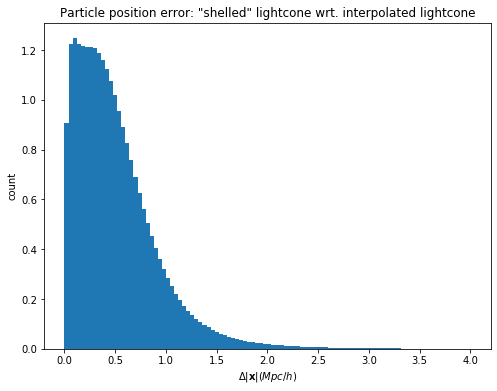

In [36]:
fig = plt.subplots(figsize = (8,6))
plt.hist(dp1 , density=True, log=False, bins=100, range = (0,4))
plt.xlabel('$\Delta \| \mathbf{x} \|(Mpc/h)$')
plt.ylabel('count')
plt.title('Particle position error: "shelled" lightcone wrt. interpolated lightcone')
#plt.legend()
#plt.savefig('error_histogram.png')
plt.show()

In [40]:
bin_means, bin_edges, binnumber = stats.binned_statistic(R1, dp1, statistic='mean', bins=1000)

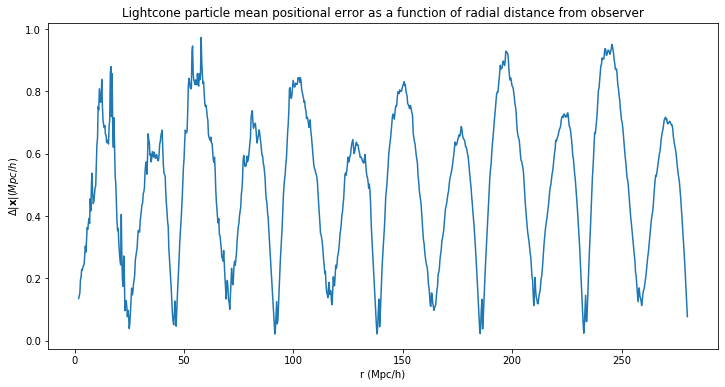

In [42]:
plt.figure(figsize = (12,6))
plt.plot(bin_edges[1::], bin_means, label='All snapshots')
#plt.legend()
plt.ylabel('$\Delta \| \mathbf{x} \|(Mpc/h)$')
plt.xlabel('r (Mpc/h)')
plt.title('Lightcone particle mean positional error as a function of radial distance from observer')
#plt.savefig('mean_error_vs_r.png')
plt.show()

In [39]:
v = np.sqrt(Vel['x']**2 + Vel['y']**2 + Vel['z']**2)
r = np.sqrt(Pos['x']**2 + Pos['y']**2 + Pos['z']**2)

In [45]:
v1 = np.sqrt(po['vel']['x']**2 + po['vel']['y']**2 + po['vel']['z']**2)
r1 = np.sqrt(po['pos']['x']**2 + po['pos']['y']**2 + po['pos']['z']**2)

In [46]:
bin_means, bin_edges, binnumber = stats.binned_statistic(r, v, statistic='mean', bins=1000)
bin_means1, bin_edges1, binnumber1 = stats.binned_statistic(r1, v1, statistic='mean', bins=1000)

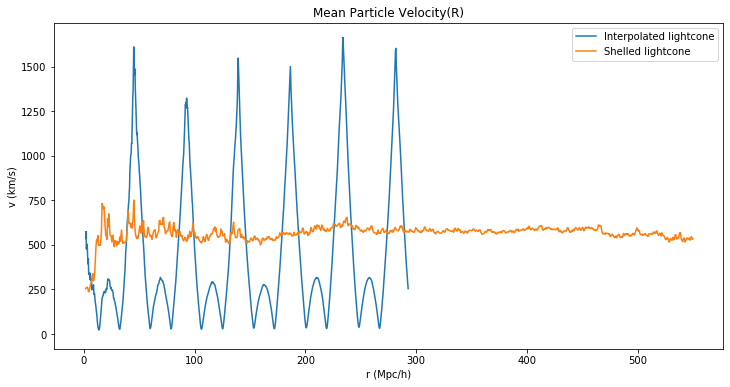

In [48]:
plt.figure(figsize = (12,6))
plt.plot(bin_edges[1::], bin_means, label = 'Interpolated lightcone')
plt.plot(bin_edges1[1::], bin_means1, label = 'Shelled lightcone')
plt.legend()
plt.xlabel('r (Mpc/h)')
plt.ylabel('v (km/s)')
plt.title('Mean Particle Velocity(R)')
plt.savefig('velocity_vs_r.png')
plt.show()

In [ ]:
        # generate a set of random numbers
        RR = np.random.rand(NumLCPart)

        for i in range(10):
            print("RR:= %14.7f"%(RR[i]))
    
        # Create a sub-sample of the lightcone particles
        ip = 0
        for i in range(NumLCPart):
            if(RR[i]<=frac):
                ip = ip+1

        for i in range(NumLCPart):
            zz = parts[i][0][2]
            if( (RR[i]<=frac) and (zz>0.0) ):
                PosSamp[nsamp,:]=parts[i][0][:]
                VelSamp[nsamp,:]=vels[i][0][:]
                IdsSamp[nsamp]=IDs[i][0]
                nsamp = nsamp+1

        print(nsamp)

In [9]:
# compute the max and min radius

radMax=571.1059013
radMin=433.7605581    

radHi = 0.0
radLo = 1.0e32

for i in range(nsamp):
    rad= PosSamp[i,0]**2+PosSamp[i,1]**2+PosSamp[i,2]**2
    rad = np.sqrt(rad)
    if(rad>radHi):
        radHi=rad
    if(rad<radLo):
        radLo=rad
print("radHi:=%14.7f\tradLo:=%14.7f"%(radHi,radLo))

radHi:=   704.7795902	radLo:=   292.7623781


In [11]:
iout = 0
nout = 1
ThisPlot = 1

iplot = 0
if iplot == 1:

    print("PLOTTING LIGHTCONE")
    
    # loop over plots
    for iout in range(nout):

        xmin = np.min(PosSamp[:nsamp,0])
        xmax = np.max(PosSamp[:nsamp,0])

        ymin = np.min(PosSamp[:nsamp,1])
        ymax = np.max(PosSamp[:nsamp,1])

        delx=xmax-xmin
        dely=ymax-ymin
        
        print(xmin,xmax,ymin,ymax)
        
        limits = [xmin,xmax,ymin,ymax]
        
        fig = plt.figure(ThisPlot,(7.0,7.0))
        
        plt.axes([0.1,0.1,0.84,0.84])
        
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        
        plt.axis(limits)
        
        plt.xlabel(r"$x [h^{-1}\,{\rm Mpc}]$",size='x-large')
        plt.ylabel(r"$y [h^{-1}\,{\rm Mpc}]$",size='x-large')
        
        plt.scatter(PosSamp[:nsamp,0],PosSamp[:nsamp,1],color='r',marker='.',s=1)
        
        plotname = 'PLOTS/Lightcone-MPI-TEST.pdf'
    
        #plt.savefig(plotname, format='pdf')
    
        plt.plot()
        plt.close(fig)

        ThisPlot+=1


In [ ]:
# use a CIC assignment to interpolate particles on to image

bounds = np.zeros(4)

xmin = np.min(PosSamp[:nsamp,0])
xmax = np.max(PosSamp[:nsamp,0])
ymin = np.min(PosSamp[:nsamp,1])
ymax = np.max(PosSamp[:nsamp,1])

bounds = [xmin,xmax,ymin,ymax]

npixX = 1000
npixY = 1000

Array = np.zeros((npixX,npixY))
LogArray = np.zeros((npixX,npixY))

Array = CIC(bounds,nsamp,PosSamp[:nsamp,0],PosSamp[:nsamp,1],npixX,npixY)

Array += 1.0

LogArray[:,:] = -np.log(Array[:,:])

In [ ]:
# plot the array

iplot = 1
if iplot == 1:

    print("PLOTTING CIC INTERPOLATED LIGHTCONE")
    
    xmin = np.min(PosSamp[:nsamp,0])
    xmax = np.max(PosSamp[:nsamp,0])

    ymin = np.min(PosSamp[:nsamp,1])
    ymax = np.max(PosSamp[:nsamp,1])

    delx=xmax-xmin
    dely=ymax-ymin
        
    print(xmin,xmax,ymin,ymax)
    
    limits = [xmin,xmax,ymin,ymax]
    
    fig = plt.figure(ThisPlot,(8.0,7.0))
    
    plt.axes([0.1,0.1,0.85,0.85])
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    plt.xlabel(r"$x [h^{-1}\,{\rm Mpc}]$",size='x-large')
    plt.ylabel(r"$y [h^{-1}\,{\rm Mpc}]$",size='x-large')
    
    #plt.scatter(PosSamp[:ns,0],PosSamp[:ns,1],color='r',marker='.',s=1)
    
    plt.imshow(LogArray,cmap="Blues",interpolation="bicubic")
    cbar = plt.colorbar(orientation='vertical',shrink=0.9,aspect=30,pad=0.02)
    cbar.set_label(r'$-\log(1+\delta)$', rotation=270,size='x-large')
    
    plotname = 'PLOTS/Lightcone-MPI_TEST.CIC.pdf'
    
    plt.savefig(plotname, format='pdf')
    
    plt.close(fig)
    
    ThisPlot+=1
    

In [ ]:
# read header - not used
      
        npart = headdata['npartFile'][0][0:6]
        npartTotal = headdata['npartTotal'][0][0:6]
        npartTotalHighWord = headdata['npartTotalHighWord'][0][0:6]
        mass = headdata['mass'][0][0:6]
        time = headdata['time'][0]
        redshift = headdata['redshift'][0]
        BoxSize = headdata['BoxSize'][0]
        Omega0 = headdata['Omega0'][0]
        OmegaDE = headdata['OmegaDE'][0]
        HubbleParam = headdata['HubbleParam'][0]
        w0 = headdata['w0'][0]
        wa = headdata['wa'][0]
        num_files = headdata['num_files'][0]
        flag_sfr = headdata['flag_sfr'][0]
        flag_feedback = headdata['flag_feedback'][0]
        flag_cooling = headdata['flag_cooling'][0]
        flag_stellarage = headdata['flag_stellarage'][0]
        flag_metals = headdata['flag_metals'][0]
        flag_entropy_instead_u = headdata['flag_entropy_instead_u'][0]
        flag_doubleprecision = headdata['flag_doubleprecision'][0]
        flag_ic_info = headdata['flag_ic_info'][0]
        lpt_scalingfactor = headdata['lpt_scalingfactor'][0]
        ipartMIN = headdata['ipartMIN'][0]
        ipartMAX = headdata['ipartMAX'][0]
        
        print("npart:= %d\t%d\t%d\t%d\t%d\t%d"%
              (npart[0],npart[1],npart[2],npart[3],npart[4],npart[5]))
        print("npart total:= %d\t%d\t%d\t%d\t%d\t%d"%
              (npartTotal[0],npartTotal[1],npartTotal[2],npartTotal[3],npartTotal[4],npartTotal[5]))
        print("npart total HighWord:= %d\t%d\t%d\t%d\t%d\t%d"%
              (npartTotalHighWord[0],npartTotalHighWord[1],npartTotalHighWord[2],
               npartTotalHighWord[3],npartTotalHighWord[4],npartTotalHighWord[5]))
        print("mass:= %14.7f\t%14.7f\t%14.7f\t%14.7f\t%14.7f\t%14.7f\t"%
              (mass[0],mass[1],mass[2],mass[3],mass[4],mass[5]))
        print("time:= %14.7f, redshift:= %14.7f"%(time,redshift))
        print("BoxSize:= %14.7f"%(BoxSize))
        print("Omega0:= %14.7f;\tOmegaDE:=%14.7f;\tHubbleParam:=%14.7f"%(Omega0,OmegaDE,HubbleParam))
        print("w0:= %14.7f;\twa:=%14.7f\t"%(w0,wa))
        print("Number of files:= %d"%(num_files))
        #print(flag_sfr,flag_feedback,flag_cooling,flag_doubleprecision,flag_ic_info)
        #print(ipartMIN,ipartMAX)
        